<a href="https://colab.research.google.com/github/MeazaEyakem1/Generating-Image-using-GAN/blob/main/Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generative Adversarial Network for generating Images 

In [ ]:
import torch 
torch.manual_seed(0)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda'
batch_size = 128
noise_dim = 64

#optimizers parameters
lr = 0.0082
beta_1 = 0.5
beta_2 = 0.99

#training variables

epochs = 30

# Load MNIST Dataset 

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
                        T.RandomRotation((-28,28)),
                        T.ToTensor() #h,w,c->c,h,w
])

In [ ]:
train_set = datasets.MNIST('MNIST/', download = True, train= True, transform = train_augs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


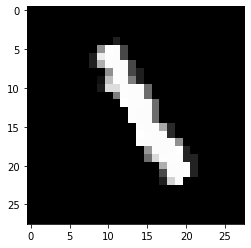

In [ ]:
image, label = train_set[6]

plt.imshow(image.squeeze(), cmap='gray')


# Load Dataset Into Batches 

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

In [ ]:
print('total no of batches in trainloader:', len(trainloader))

total no of batches in trainloader: 469


In [ ]:
dataiter = iter(trainloader)

images, _ = dataiter.next()

print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

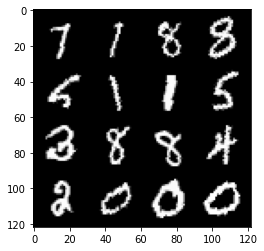

In [ ]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network 

In [ ]:
#In case if torch summary is not installed 

!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
def get_discri_block(in_channels, out_channels, kernel_size, stride):

  return nn.Sequential(
      
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.block_1 = get_discri_block(1,16,(3,3),2)
    self.block_2 = get_discri_block(16,32,(5,5),2)
    self.block_3 = get_discri_block(32,64,(5,5),2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self,images):
    
    X1 = self.block_1(images)
    X2 = self.block_2(X1)
    X3 = self.block_3(X2)

    X4 = self.flatten(X3)
    X5 = self.linear(X4)

    return X5



In [ ]:
D = Discriminator()
D.to(device)

summary(D,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256,(3,3),2)
    self.block_2 = get_gen_block(256,128,(4,4),1)
    self.block_3 = get_gen_block(128,64,(3,3),2)

    self.block_4 = get_gen_block(64,1,(4,4),2,final_block = True)

  def forward(self,r_noise_vec):

    X = r_noise_vec.view(-1, self.noise_dim, 1,1)

    X1 = self.block_1(X)
    X2 = self.block_2(X1)
    X3 = self.block_3(X2)

    X4 = self.block_4(X3)

    return X4



    



In [ ]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  Criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = Criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  Criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = Criterion(disc_pred,ground_truth)
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1,beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1,beta_2))

# Training Loop 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1| D_loss: 0.620088523893214| G_loss:0.620088523893214


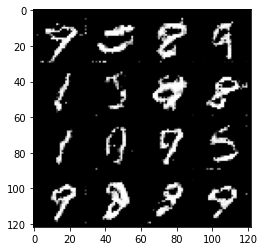

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2| D_loss: 0.6298922258399443| G_loss:0.6298922258399443


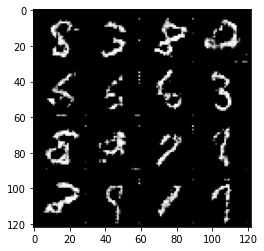

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3| D_loss: 0.6449641629831114| G_loss:0.6449641629831114


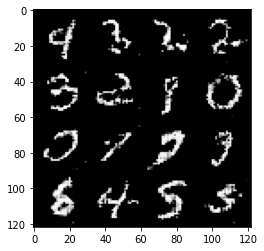

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4| D_loss: 0.6468366933529819| G_loss:0.6468366933529819


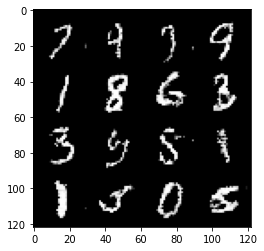

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5| D_loss: 0.641729077042293| G_loss:0.641729077042293


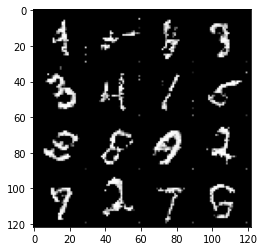

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6| D_loss: 0.6371312639606532| G_loss:0.6371312639606532


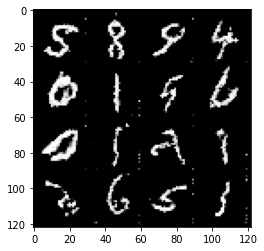

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7| D_loss: 0.6313850183222594| G_loss:0.6313850183222594


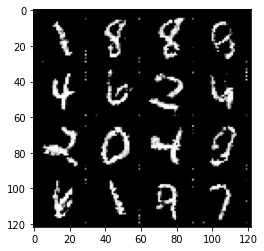

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8| D_loss: 0.6296327217047148| G_loss:0.6296327217047148


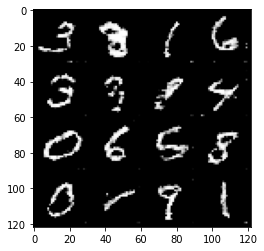

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9| D_loss: 0.6280483547558409| G_loss:0.6280483547558409


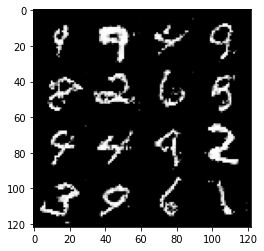

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10| D_loss: 0.6243573034495942| G_loss:0.6243573034495942


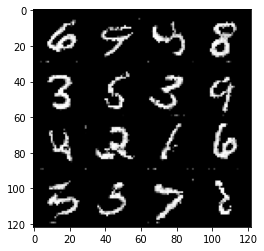

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11| D_loss: 0.6250068568217475| G_loss:0.6250068568217475


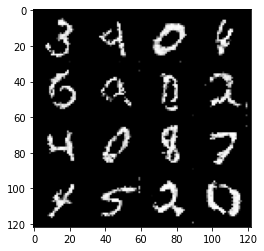

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:12| D_loss: 0.6248370317507909| G_loss:0.6248370317507909


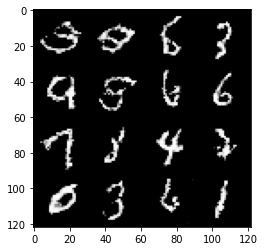

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:13| D_loss: 0.6229734144993683| G_loss:0.6229734144993683


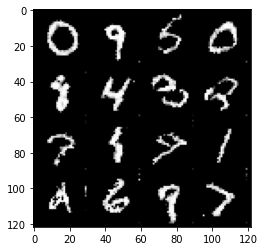

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:14| D_loss: 0.622184810862104| G_loss:0.622184810862104


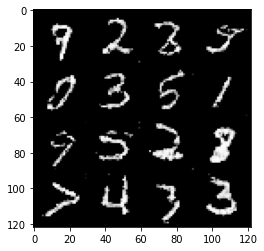

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:15| D_loss: 0.6209752789692584| G_loss:0.6209752789692584


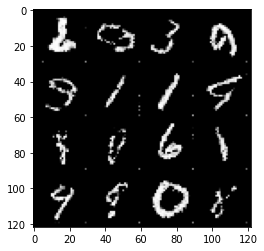

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:16| D_loss: 0.6180731884197894| G_loss:0.6180731884197894


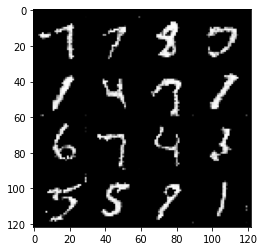

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:17| D_loss: 0.6190259719708326| G_loss:0.6190259719708326


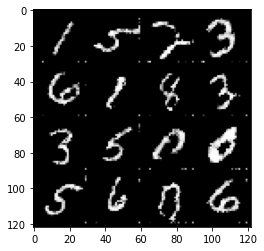

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:18| D_loss: 0.6170951579171203| G_loss:0.6170951579171203


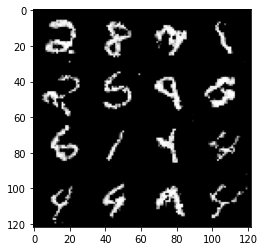

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:19| D_loss: 0.6145726815978093| G_loss:0.6145726815978093


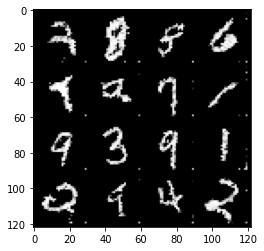

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:20| D_loss: 0.6118794187808088| G_loss:0.6118794187808088


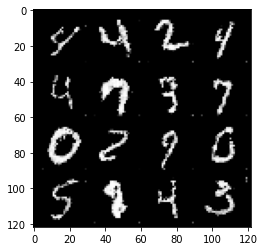

In [ ]:
for i in range(epochs):
  
  total_D_loss = 0.0
  total_G_loss = 0.0

  for real_image, _ in trainloader:
    
    real_image = real_image.to(device)
    noise = torch.randn(batch_size,noise_dim,device = device)

    #find loss and update weights for D

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_real_pred = D(real_image)
    D_real_loss = real_loss(D_real_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_D_loss = total_D_loss + D_loss.item()

    D_loss.backward()
    D_opt.step()

    #find loss and update weights for G

    noise = torch.randn(batch_size,noise_dim,device = device)


    G_opt.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_G_loss = total_G_loss + G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_D_loss/len(trainloader)
  avg_g_loss = total_G_loss/len(trainloader)

  print("Epoch:{}| D_loss: {}| G_loss:{}".format(i+1, avg_d_loss, avg_d_loss))


  show_tensor_images(fake_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


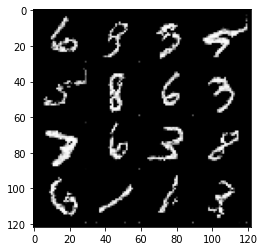

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)